# Annot

задача:

>Химическая промышленность: Веб-приложение, которое на основе ИИ будет используется для отслеживания химического состава природных водных ресурсов. Оно будет анализировать изменения в составе воды и предоставлять рекомендации для минимизации воздействия на окружающую среду и на здоровье человека.



In [1]:
import os
import pandas as pd
import numpy as np
import pickle

from typing import List

import seaborn as sns
from matplotlib import pylab as plt
%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({"font.size": 14})

# Данные + EDA

Данные найдены на Kaggle (https://www.kaggle.com/datasets/adityakadiwal/water-potability)

In [2]:
data = pd.read_csv("../data/water_potability.csv")
print(f"Датасет содержит {data.shape[0]} строк и {data.shape[1]} столбцов")
init_columns = data.columns

Датасет содержит 3276 строк и 10 столбцов


In [3]:
data.sample()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
2328,6.071839,217.826531,17162.753927,3.521125,319.037346,612.094926,16.542239,64.826308,2.69161,1


> Определим пропущенные данные

In [4]:
for col in data.columns:
    print(f"{col:30s} :: {str(data[col].isna().sum()):4s} {data[col].isna().sum() / data.shape[0] * 100:.0f}%")

ph                             :: 491  15%
Hardness                       :: 0    0%
Solids                         :: 0    0%
Chloramines                    :: 0    0%
Sulfate                        :: 781  24%
Conductivity                   :: 0    0%
Organic_carbon                 :: 0    0%
Trihalomethanes                :: 162  5%
Turbidity                      :: 0    0%
Potability                     :: 0    0%


> Так как предполагается работа в продакшене, используем дополнительные фичи для маркировки пропусков в данных. Более того, подобный подход позволит обучить более устойчивую модель.

In [5]:
for col in data.columns:
    if col != "Potability":
        data[f"{col}_nan"] = data[col].isna().astype(int)
        data.loc[data[col].isna(), col] = 0.0
data.sample()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,ph_nan,Hardness_nan,Solids_nan,Chloramines_nan,Sulfate_nan,Conductivity_nan,Organic_carbon_nan,Trihalomethanes_nan,Turbidity_nan
19,7.37105,214.49661,25630.320037,4.432669,335.754439,469.914551,12.509164,62.797277,2.560299,0,0,0,0,0,0,0,0,0,0


In [6]:
print(f"Пропусков в обогащенных данных: {data.isna().sum().sum()}")

Пропусков в обогащенных данных: 0


> Посмотрим на корреляции между целевой переменной и исходными колонками

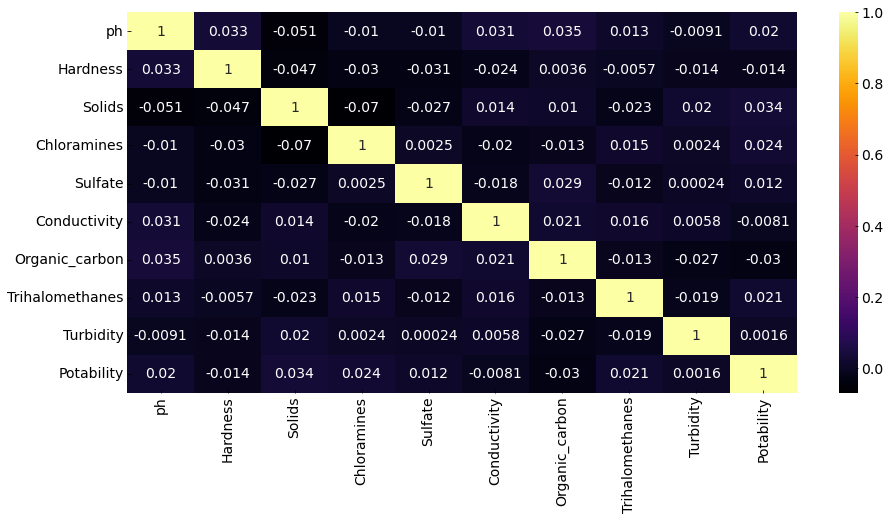

In [7]:
corr = data[init_columns].corr()
plt.figure(figsize=(15, 7))
sns.heatmap(corr, cmap="inferno", annot=True) 
plt.show()

> Данные достаточно чистые, в плане внутренних корреляций. Нет сильно коррелированных фичей.

Визуализируем распределения значений

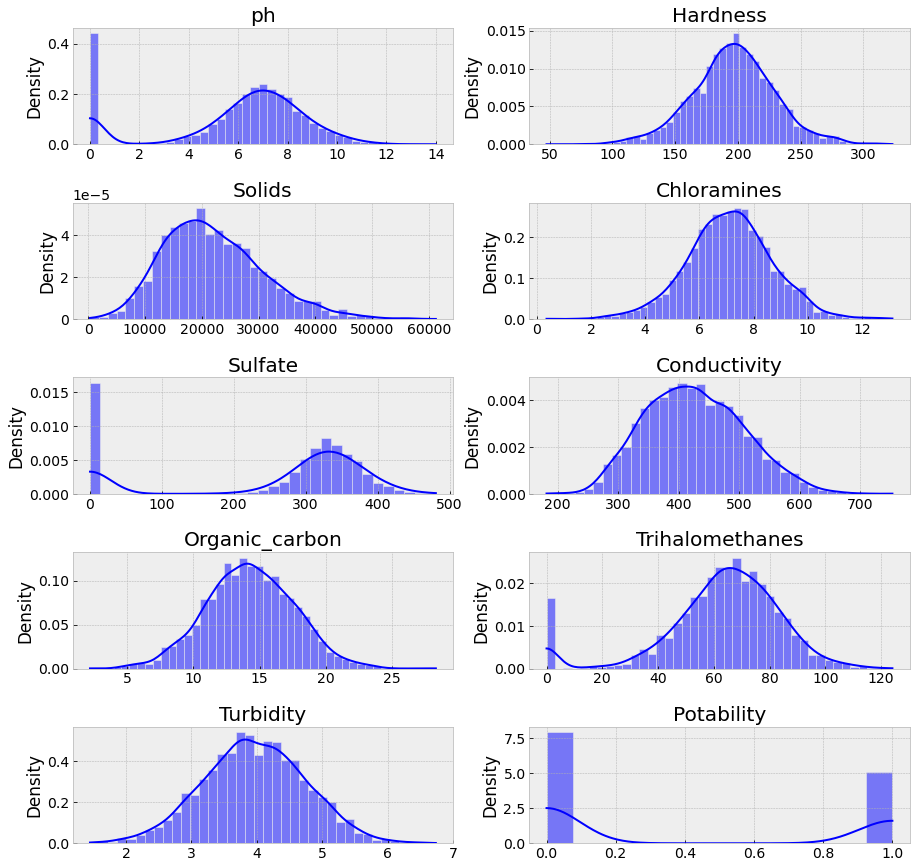

In [8]:
fig, ax = plt.subplots(5, 2, figsize=(15, 15))

for idx, col in enumerate(init_columns):
    sns.histplot(data[col], ax=ax[idx // 2, idx % 2], kde=True, stat='density')
    ax[idx // 2, idx % 2].set_title(col)
    ax[idx // 2, idx % 2].set_xlabel("")
plt.subplots_adjust(hspace=0.5)

> Данные распределены близко к нормальному распределению. Только `Solids` немного смещен. Проверим на выбросы. Нули - замещенные NaN

In [9]:
def get_outliners(x: np.ndarray) -> int:
    """Реализация выявления выбросов, которые не укладываются в 1.5 * IQR
    
    Args:
        x (np.ndarray): входной набор данных (вектор)
    
    Returns:
        (int): количество выбросов
    """
    iqr = 1.5 * (np.quantile(x, 0.75) - np.quantile(x, 0.25))
    low_bond = x.median() - iqr
    upper_bound = x.median() + iqr
    return np.where(x > upper_bound)[0].size + np.where(x < low_bond)[0].size

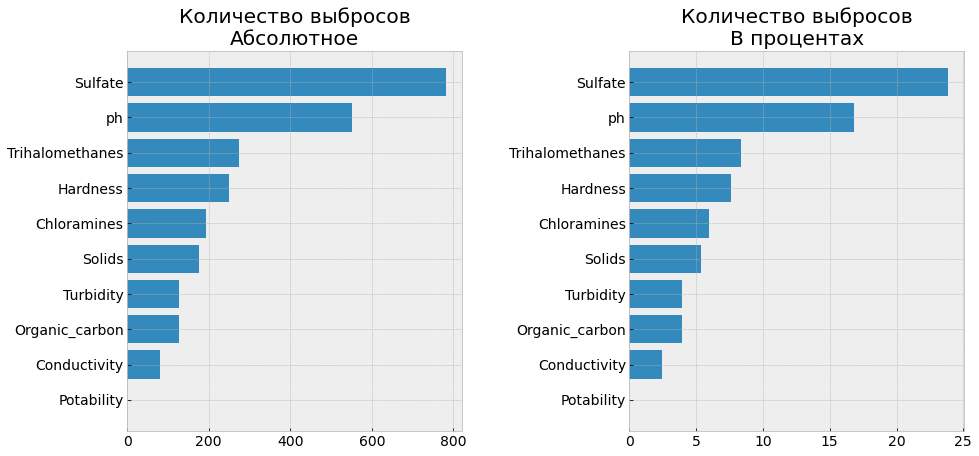

In [10]:
_temp_series = pd.Series({col: get_outliners(data[col]) for col in init_columns})
_temp_series = _temp_series.sort_values()

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].barh(_temp_series.index, _temp_series.values)
ax[0].set_title("Количество выбросов\nАбсолютное")
ax[1].barh(_temp_series.index, _temp_series.values / len(data) * 100)
ax[1].set_title("Количество выбросов\nВ процентах")
plt.subplots_adjust(wspace=0.5)
plt.show()

> Так как выбросов либо нет, либо они не единичные (от 2.5 % значений фичи) можно заключить, что это не выбросы, а **особенности данных**

# Train

Будем учить XGBoost [на GPU, чтоб побыстрее, в инференсе будет CPU]. Параметры найдем перебором.

План обучения:
* baseline на чистом датасете
* повышение устойчивости путем генерации пропусков в данных

In [11]:
import time
import pickle

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, roc_auc_score, accuracy_score, mutual_info_score

In [12]:
def get_metrics(classifier, x: pd.DataFrame, y: pd.Series, name: str, training_time: str, num_classes: int) -> dict:
    """Функция для оценки качества обучения
    Args:
        clasifier объект классификатора с методами predict и predict_proba
        x (pd.DataFrame) признаки
        y (pd.Series) лейблы
        name (str) имя классификатора
        training_time (str) время обучения (включая тюнинг) в формате чч:мм:cc
        num_classes (int) число классов
    Return:
        (dict) структуру строки для датасета с результатами
    """
    preds = classifier.predict(x)
    preds_proba = classifier.predict_proba(x)
    return {
        "model": [name],
        "time": [training_time],
        "accuracy": [accuracy_score(y, preds)],
        "recall": [recall_score(y, preds)],
        "roc_auc": [roc_auc_score(np.eye(num_classes)[y], preds_proba)],
        "f1_score": [f1_score(y, preds)],
        "mutal_score": [mutual_info_score(y, preds)],
    }

> Обучение baseline

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['Potability']), data['Potability'], random_state=6875, train_size=0.8
)

In [14]:
model = XGBClassifier()
parameters = {
    "n_estimators": [10, 25, 50, 100, 150, 200, 250],
    "max_depth": [5, 10, 15, 20],
    "learning_rate": [1e-2, 1e-3, 1e-5],
    "objective": ["binary:logistic"],
    "eval_metric": ["auc"],
    "tree_method": ["gpu_hist"],
}

In [15]:
clf = GridSearchCV(model, parameters, cv=2, verbose=False)
start = time.time()
clf.fit(X_train, y_train)
train_time = time.time() - start

In [16]:
metrics_frame = pd.DataFrame(get_metrics(clf.best_estimator_, X_test, y_test, "search", train_time, 2))
metrics_frame

,model,time,accuracy,recall,roc_auc,f1_score,mutal_score
0,search,85.754553,0.682927,0.369919,0.682144,0.466667,0.038577


In [20]:
pickle.dump(clf.best_estimator_, open("../models/baseline.bin", "wb"))

> На тестовых данных ROC AUC в районе 0.68, что в целом, соответсвует результатам из откртых источников (расшаренный код)

**Обогащение данных**

Для обогащения данных в случайных местах пропускаем данные и ставим колонку в соотвесвующее состояние. Увеличим датасет в 10 раз (по количеству фичей + исходный)

In [21]:
X_train_large = X_train.copy()
y_train_large = y_train.copy()
for col in init_columns:
    if col != 'Potability':
        _temp_frame = X_train.copy()
        _temp_frame[col] = 0.0
        _temp_frame[f'{col}_nan'] = 1
    X_train_large = pd.concat([X_train_large, _temp_frame], ignore_index=True)
    y_train_large = pd.concat([y_train_large, y_train.copy()], ignore_index=True)
print(f"Размерность нового датасета: {len(X_train_large)}")

Размерность нового датасета: 28820


In [22]:
clf = GridSearchCV(model, parameters, cv=2, verbose=False)
start = time.time()
clf.fit(X_train_large, y_train_large)
train_time = time.time() - start

In [23]:
metrics_frame = pd.concat([
    metrics_frame, pd.DataFrame(get_metrics(clf.best_estimator_, X_test, y_test, "large", train_time, 2))
], ignore_index=True)
pickle.dump(clf.best_estimator_, open("../models/robust.bin", "wb"))

In [24]:
metrics_frame

,model,time,accuracy,recall,roc_auc,f1_score,mutal_score
0,search,85.754553,0.682927,0.369919,0.682144,0.466667,0.038577
1,large,237.992343,0.660061,0.398374,0.672606,0.467780,0.027405


> Как видим качество не сильно упало, однако повысилась устойчивотсь - теперь модель может работать с неполными данными

## Сформируем базу данных для Web-api

In [11]:
import sqlite3
con = sqlite3.connect("../main_base.db")

In [12]:
data.to_sql('train_data', con, index=False)

3276